In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "5"

In [2]:
!python --version

Python 3.10.10


In [3]:
!nvidia-smi

Wed Oct  9 15:10:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100S-PCIE-32GB          On  | 00000000:03:00.0 Off |                    0 |
| N/A   35C    P0              36W / 250W |   6133MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
import torch

def check_cuda():
    if torch.cuda.is_available():
        print(f"CUDA is available! PyTorch can use GPU.")
        print(f"Number of GPUs available: {torch.cuda.device_count()}")
        print(f"Current GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    else:
        print("CUDA is not available. PyTorch will use the CPU.")

if __name__ == "__main__":
    check_cuda()


CUDA is available! PyTorch can use GPU.
Number of GPUs available: 1
Current GPU: Tesla V100S-PCIE-32GB


In [6]:
import torch
import time

# GPU 사용 가능 여부 체크
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 간단한 텐서를 생성하여 GPU로 이동
x = torch.randn(10000, 10000)

# CPU에서 연산 시간 측정
start_time = time.time()
x_cpu = x.mm(x)  # 행렬 곱셈
end_time = time.time()
print(f"CPU computation time: {end_time - start_time:.4f} seconds")

# 텐서를 GPU로 이동 (가능한 경우)
x = x.to(device)

# GPU에서 연산 시간 측정 (GPU가 사용 가능한 경우만)
if device.type == 'cuda':
    start_time = time.time()
    x_gpu = x.mm(x)  # 행렬 곱셈
    torch.cuda.synchronize()  # GPU 작업이 끝날 때까지 대기
    end_time = time.time()
    print(f"GPU computation time: {end_time - start_time:.4f} seconds")
else:
    print("GPU is not available, running on CPU.")


CPU computation time: 1.6778 seconds
GPU computation time: 0.2183 seconds


In [7]:
if torch.cuda.is_available():
    print(f"Allocated memory: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
print(x_gpu.device)  # 출력: cuda:0 (GPU에서 연산 중인 경우)


Allocated memory: 772.12 MB
Cached memory: 784.00 MB
cuda:0


In [8]:
# GPU 연산 동기화
torch.cuda.synchronize()

## EfficientNetV2

In [9]:
import os
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import torch.cuda as cuda

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduce_ratio = 4):
        super(SEBlock, self).__init__()
        reduced_channels = in_channels // reduce_ratio
        self.fc1 = nn.Conv2d(in_channels, reduced_channels, kernel_size=1)
        self.fc2 = nn.Conv2d(reduced_channels, in_channels, kernel_size=1)

    def forward(self, x):
        se = F.adaptive_avg_pool2d(x, 1)
        se = torch.relu(self.fc1(se))
        se = torch.sigmoid(self.fc2(se))
        return x * se
    
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion, stride, se_ratio = 0.25):
        super(MBConv, self).__init__()
        self.use_residual = stride == 1 and in_channels == out_channels
        mid_channels = in_channels * expansion

        self.expand_conv = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.deptwise_conv = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride = stride, padding=1, groups=mid_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.se = SEBlock(mid_channels, reduce_ratio = int(1 / se_ratio))
        self.project_conv = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        residual = x
        x = self.act(self.bn1(self.expand_conv(x)))
        x = self.act(self.bn2(self.deptwise_conv(x)))
        x = self.se(x)
        x = self.bn3(self.project_conv(x))
        if self.use_residual:
            x += residual
        return x
    
class FusedMBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion, stride):
        super(FusedMBConv, self).__init__()
        self.use_residual = stride == 1 and in_channels == out_channels
        mid_channels = in_channels * expansion

        self.expand_conv = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=stride, padding=1, bias=False) if expansion != 1 else None
        self.bn1 = nn.BatchNorm2d(mid_channels if expansion != 1 else in_channels)
        self.project_conv = nn.Conv2d(mid_channels if expansion != 1 else in_channels, out_channels, kernel_size=1 if expansion != 1 else 3, stride=1, padding = 1 if expansion == 1 else 0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        residual = x
        if self.expand_conv:
            x = self.act(self.bn1(self.expand_conv(x)))
        else:
            x = self.act(self.bn1(x))
        x = self.bn2(self.project_conv(x))
        if self.use_residual:
            x += residual
        return x


class EfficientNetV2(nn.Module):
    def __init__(self, num_classes=27):
        super(EfficientNetV2, self).__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(24),
            nn.SiLU()
        )
        # (block type, repeats, in_channels, out_channels, expansion, stride)
        self.block_config = [
            (FusedMBConv, 2, 24, 24, 1, 1),
            (FusedMBConv, 4, 24, 48, 4, 2),
            (FusedMBConv, 4, 48, 64, 4, 2),
            (MBConv, 6, 64, 128, 4, 2),
            (MBConv, 9, 128, 160, 6, 1),
            (MBConv, 15, 160, 256, 6, 2)
        ]

        layers = []
        for block, repeats, in_channels, out_channels, expansion, stride in self.block_config:
            for i in range(repeats):
                if i == 0:
                    layers.append(block(in_channels, out_channels, expansion, stride))
                else:
                    layers.append(block(out_channels, out_channels, expansion, 1))
        self.blocks = nn.Sequential(*layers)

        self.head = nn.Sequential(
        nn.Conv2d(256,1280, kernel_size=1, bias=False),
        nn.BatchNorm2d(1280),
        nn.SiLU(),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        return x
        
model = EfficientNetV2(num_classes = 27)
print(model)

EfficientNetV2(
  (stem): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (blocks): Sequential(
    (0): FusedMBConv(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (project_conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (1): FusedMBConv(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (project_conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (2): FusedMBConv(
      (expand_conv): Conv2d(24, 96, kernel_size=(3, 3

In [10]:
# import torch
# from torch.autograd import Variable
# from torchviz import make_dot

# # Dummy input to visualize the model
# dummy_input = Variable(torch.randn(1, 3, 224, 224))
# dummy_input = dummy_input.to("cuda")

# # Load the EfficientNetV2 model
# model = EfficientNetV2(num_classes=1000).to("cuda")

# # Pass the dummy input through the model to trace the graph
# output = model(dummy_input)

# # Generate the visualization graph
# dot = make_dot(output, params=dict(list(model.named_parameters())))

# # Save and display the graph
# dot.format = 'png'
# dot.render('efficientnet_v2_model_plot')

# # The graph will be saved as efficientnet_v2_model_plot.png

In [11]:
csv_path = 'filtered_wikiart_train_test.csv'

# CSV 파일 로드
df = pd.read_csv(csv_path)

# 이미지가 존재하는 행만 필터링
df = df[df['filename'].apply(lambda x: os.path.exists(x))]

unique_labels = df['label'].unique()

# 문자열 레이블을 숫자로 매핑하는 딕셔너리 생성
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        img_path = self.df.iloc[idx]['filename']
        label = self.df.iloc[idx]['label']

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label_to_idx[label], dtype=torch.long)

        return image, label
        
data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

train_dataset = CustomDataset(df[df['subset'] == 'train'], transform=data_transforms['train'])
test_dataset = CustomDataset(df[df['subset'] == 'test'], transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [15]:
df['subset'].value_counts()

subset
train    1584
test      373
Name: count, dtype: int64

In [17]:
# # EfficientNetV2 모델 학습 코드
# def train_model(model, criterion, optimizer, num_epochs=300):
#     start_time = time.time()
#     best_accuracy = 0.0

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         # tqdm 적용 (train)
#         for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
#             images = images.to(device)
#             labels = labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * images.size(0)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         epoch_loss = running_loss / len(train_dataset)
#         epoch_accuracy = correct / total

#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

#         # Validation
#         model.eval()
#         val_correct = 0
#         val_total = 0
#         with torch.no_grad():
#             # tqdm 적용 (validation)
#             for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
#                 images = images.to(device)
#                 labels = labels.to(device)
#                 outputs = model(images)
#                 _, predicted = torch.max(outputs, 1)
#                 val_total += labels.size(0)
#                 val_correct += (predicted == labels).sum().item()

#         val_accuracy = val_correct / val_total
#         print(f"Validation Accuracy: {val_accuracy:.4f}")

#         # Best model 저장
#         if val_accuracy > best_accuracy:
#             best_accuracy = val_accuracy
#             torch.save(model.state_dict(), "best_model(EfficientNetV2).pth")

#     elapsed_time = time.time() - start_time
#     print(f"Training completed in {elapsed_time//60:.0f}m {elapsed_time%60:.0f}s")
#     print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# # GPU 사용 설정
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # EfficientNetV2 모델 정의
# model = EfficientNetV2(num_classes=len(unique_labels)).to(device)

# # 손실 함수와 옵티마이저 정의
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # 모델 학습
# train_model(model, criterion, optimizer, num_epochs=300)

cuda


Epoch 1/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.39it/s]


Epoch 1/300, Loss: 3.3746, Accuracy: 0.0496


Epoch 1/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.44it/s]


Validation Loss: 4.1193, Validation Accuracy: 0.0567


Epoch 2/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.16it/s]


Epoch 2/300, Loss: 3.2890, Accuracy: 0.0593


Epoch 2/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.68it/s]


Validation Loss: 3.3223, Validation Accuracy: 0.0731


Epoch 3/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.05it/s]


Epoch 3/300, Loss: 3.2852, Accuracy: 0.0593


Epoch 3/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.51it/s]


Validation Loss: 3.2282, Validation Accuracy: 0.0664


Epoch 4/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.41it/s]


Epoch 4/300, Loss: 3.2514, Accuracy: 0.0572


Epoch 4/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.66it/s]


Validation Loss: 3.2078, Validation Accuracy: 0.0675


Epoch 5/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.11it/s]


Epoch 5/300, Loss: 3.2183, Accuracy: 0.0618


Epoch 5/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.69it/s]


Validation Loss: 3.1444, Validation Accuracy: 0.0925


Epoch 6/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.52it/s]


Epoch 6/300, Loss: 3.1651, Accuracy: 0.0710


Epoch 6/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.57it/s]


Validation Loss: 3.0480, Validation Accuracy: 0.1088


Epoch 7/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.16it/s]


Epoch 7/300, Loss: 3.1165, Accuracy: 0.0879


Epoch 7/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.42it/s]


Validation Loss: 3.0087, Validation Accuracy: 0.1145


Epoch 8/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.34it/s]


Epoch 8/300, Loss: 3.1142, Accuracy: 0.0899


Epoch 8/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.75it/s]


Validation Loss: 3.0100, Validation Accuracy: 0.1078


Epoch 9/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.24it/s]


Epoch 9/300, Loss: 3.0644, Accuracy: 0.1119


Epoch 9/300 [Validation]: 100%|██████████| 123/123 [00:13<00:00,  9.00it/s]


Validation Loss: 3.0185, Validation Accuracy: 0.1109


Epoch 10/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.68it/s]


Epoch 10/300, Loss: 3.0411, Accuracy: 0.1073


Epoch 10/300 [Validation]: 100%|██████████| 123/123 [00:13<00:00,  8.80it/s]


Validation Loss: 2.9956, Validation Accuracy: 0.1221


Epoch 11/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.39it/s]


Epoch 11/300, Loss: 3.0366, Accuracy: 0.1078


Epoch 11/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.55it/s]


Validation Loss: 2.8929, Validation Accuracy: 0.1349


Epoch 12/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.08it/s]


Epoch 12/300, Loss: 3.0084, Accuracy: 0.1139


Epoch 12/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.73it/s]


Validation Loss: 2.9241, Validation Accuracy: 0.1313


Epoch 13/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.18it/s]


Epoch 13/300, Loss: 2.9824, Accuracy: 0.1134


Epoch 13/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.45it/s]


Validation Loss: 2.8544, Validation Accuracy: 0.1671


Epoch 14/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.12it/s]


Epoch 14/300, Loss: 2.9487, Accuracy: 0.1272


Epoch 14/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.60it/s]


Validation Loss: 2.8520, Validation Accuracy: 0.1528


Epoch 15/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.15it/s]


Epoch 15/300, Loss: 2.9538, Accuracy: 0.1252


Epoch 15/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.43it/s]


Validation Loss: 2.8502, Validation Accuracy: 0.1523


Epoch 16/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.21it/s]


Epoch 16/300, Loss: 2.9468, Accuracy: 0.1364


Epoch 16/300 [Validation]: 100%|██████████| 123/123 [00:13<00:00,  8.80it/s]


Validation Loss: 2.8738, Validation Accuracy: 0.1415


Epoch 17/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.18it/s]


Epoch 17/300, Loss: 2.9359, Accuracy: 0.1334


Epoch 17/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.43it/s]


Validation Loss: 2.8193, Validation Accuracy: 0.1528


Epoch 18/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.14it/s]


Epoch 18/300, Loss: 2.9181, Accuracy: 0.1242


Epoch 18/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.42it/s]


Validation Loss: 2.8031, Validation Accuracy: 0.1507


Epoch 19/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.00it/s]


Epoch 19/300, Loss: 2.9026, Accuracy: 0.1344


Epoch 19/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.63it/s]


Validation Loss: 2.7915, Validation Accuracy: 0.1737


Epoch 20/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.07it/s]


Epoch 20/300, Loss: 2.9126, Accuracy: 0.1528


Epoch 20/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.63it/s]


Validation Loss: 2.7516, Validation Accuracy: 0.1778


Epoch 21/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.36it/s]


Epoch 21/300, Loss: 2.8793, Accuracy: 0.1528


Epoch 21/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.51it/s]


Validation Loss: 2.8221, Validation Accuracy: 0.1666


Epoch 22/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.17it/s]


Epoch 22/300, Loss: 2.8758, Accuracy: 0.1538


Epoch 22/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.68it/s]


Validation Loss: 2.7582, Validation Accuracy: 0.1742


Epoch 23/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.09it/s]


Epoch 23/300, Loss: 2.8298, Accuracy: 0.1523


Epoch 23/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.61it/s]


Validation Loss: 2.7090, Validation Accuracy: 0.1937


Epoch 24/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.34it/s]


Epoch 24/300, Loss: 2.8564, Accuracy: 0.1492


Epoch 24/300 [Validation]: 100%|██████████| 123/123 [00:13<00:00,  8.79it/s]


Validation Loss: 2.7480, Validation Accuracy: 0.1661


Epoch 25/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.28it/s]


Epoch 25/300, Loss: 2.8525, Accuracy: 0.1533


Epoch 25/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.55it/s]


Validation Loss: 2.6900, Validation Accuracy: 0.2029


Epoch 26/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.16it/s]


Epoch 26/300, Loss: 2.8309, Accuracy: 0.1656


Epoch 26/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.47it/s]


Validation Loss: 2.6784, Validation Accuracy: 0.1942


Epoch 27/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.34it/s]


Epoch 27/300, Loss: 2.7999, Accuracy: 0.1788


Epoch 27/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.75it/s]


Validation Loss: 2.6384, Validation Accuracy: 0.2100


Epoch 28/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.35it/s]


Epoch 28/300, Loss: 2.8013, Accuracy: 0.1661


Epoch 28/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.78it/s]


Validation Loss: 2.6589, Validation Accuracy: 0.1978


Epoch 29/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.36it/s]


Epoch 29/300, Loss: 2.7919, Accuracy: 0.1630


Epoch 29/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.73it/s]


Validation Loss: 2.6240, Validation Accuracy: 0.2039


Epoch 30/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.38it/s]


Epoch 30/300, Loss: 2.7834, Accuracy: 0.1742


Epoch 30/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.62it/s]


Validation Loss: 2.6637, Validation Accuracy: 0.1957


Epoch 31/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.25it/s]


Epoch 31/300, Loss: 2.7765, Accuracy: 0.1696


Epoch 31/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.69it/s]


Validation Loss: 2.6653, Validation Accuracy: 0.1993


Epoch 32/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.32it/s]


Epoch 32/300, Loss: 2.7655, Accuracy: 0.1799


Epoch 32/300 [Validation]: 100%|██████████| 123/123 [00:13<00:00,  9.02it/s]


Validation Loss: 2.5985, Validation Accuracy: 0.2136


Epoch 33/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.39it/s]


Epoch 33/300, Loss: 2.7533, Accuracy: 0.1952


Epoch 33/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.47it/s]


Validation Loss: 2.6035, Validation Accuracy: 0.2151


Epoch 34/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.99it/s]


Epoch 34/300, Loss: 2.7678, Accuracy: 0.1880


Epoch 34/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.46it/s]


Validation Loss: 2.6385, Validation Accuracy: 0.2095


Epoch 35/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.05it/s]


Epoch 35/300, Loss: 2.7545, Accuracy: 0.1814


Epoch 35/300 [Validation]: 100%|██████████| 123/123 [00:13<00:00,  8.81it/s]


Validation Loss: 2.6101, Validation Accuracy: 0.2146


Epoch 36/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.16it/s]


Epoch 36/300, Loss: 2.7392, Accuracy: 0.1865


Epoch 36/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.49it/s]


Validation Loss: 2.5583, Validation Accuracy: 0.2289


Epoch 37/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.23it/s]


Epoch 37/300, Loss: 2.7269, Accuracy: 0.1998


Epoch 37/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.45it/s]


Validation Loss: 2.5712, Validation Accuracy: 0.2238


Epoch 38/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.23it/s]


Epoch 38/300, Loss: 2.7369, Accuracy: 0.1778


Epoch 38/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.73it/s]


Validation Loss: 2.5628, Validation Accuracy: 0.2284


Epoch 39/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.42it/s]


Epoch 39/300, Loss: 2.7075, Accuracy: 0.2115


Epoch 39/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.68it/s]


Validation Loss: 2.5138, Validation Accuracy: 0.2468


Epoch 40/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.32it/s]


Epoch 40/300, Loss: 2.7256, Accuracy: 0.1845


Epoch 40/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.66it/s]


Validation Loss: 2.5532, Validation Accuracy: 0.2443


Epoch 41/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.34it/s]


Epoch 41/300, Loss: 2.6919, Accuracy: 0.1993


Epoch 41/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.67it/s]


Validation Loss: 2.5209, Validation Accuracy: 0.2274


Epoch 42/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.25it/s]


Epoch 42/300, Loss: 2.6973, Accuracy: 0.1916


Epoch 42/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.28it/s]


Validation Loss: 2.5014, Validation Accuracy: 0.2376


Epoch 43/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.99it/s]


Epoch 43/300, Loss: 2.6858, Accuracy: 0.2008


Epoch 43/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.45it/s]


Validation Loss: 2.5245, Validation Accuracy: 0.2330


Epoch 44/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.18it/s]


Epoch 44/300, Loss: 2.6901, Accuracy: 0.2044


Epoch 44/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.49it/s]


Validation Loss: 2.4634, Validation Accuracy: 0.2534


Epoch 45/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.14it/s]


Epoch 45/300, Loss: 2.6546, Accuracy: 0.2105


Epoch 45/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.46it/s]


Validation Loss: 2.4735, Validation Accuracy: 0.2534


Epoch 46/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.90it/s]


Epoch 46/300, Loss: 2.6582, Accuracy: 0.2090


Epoch 46/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.43it/s]


Validation Loss: 2.4625, Validation Accuracy: 0.2432


Epoch 47/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.19it/s]


Epoch 47/300, Loss: 2.6796, Accuracy: 0.1921


Epoch 47/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.14it/s]


Validation Loss: 2.4802, Validation Accuracy: 0.2570


Epoch 48/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.96it/s]


Epoch 48/300, Loss: 2.6640, Accuracy: 0.2059


Epoch 48/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.31it/s]


Validation Loss: 2.4534, Validation Accuracy: 0.2596


Epoch 49/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.92it/s]


Epoch 49/300, Loss: 2.6136, Accuracy: 0.2192


Epoch 49/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.11it/s]


Validation Loss: 2.4726, Validation Accuracy: 0.2616


Epoch 50/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.78it/s]


Epoch 50/300, Loss: 2.6489, Accuracy: 0.2233


Epoch 50/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.08it/s]


Validation Loss: 2.4271, Validation Accuracy: 0.2606


Epoch 51/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.63it/s]


Epoch 51/300, Loss: 2.6263, Accuracy: 0.2177


Epoch 51/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.47it/s]


Validation Loss: 2.4018, Validation Accuracy: 0.2729


Epoch 52/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.71it/s]


Epoch 52/300, Loss: 2.6381, Accuracy: 0.2090


Epoch 52/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.14it/s]


Validation Loss: 2.4699, Validation Accuracy: 0.2555


Epoch 53/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.61it/s]


Epoch 53/300, Loss: 2.5921, Accuracy: 0.2218


Epoch 53/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  7.93it/s]


Validation Loss: 2.4195, Validation Accuracy: 0.2764


Epoch 54/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.89it/s]


Epoch 54/300, Loss: 2.6112, Accuracy: 0.2223


Epoch 54/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.39it/s]


Validation Loss: 2.3690, Validation Accuracy: 0.2734


Epoch 55/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.59it/s]


Epoch 55/300, Loss: 2.5963, Accuracy: 0.2259


Epoch 55/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.52it/s]


Validation Loss: 2.3840, Validation Accuracy: 0.2754


Epoch 56/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.91it/s]


Epoch 56/300, Loss: 2.5911, Accuracy: 0.2305


Epoch 56/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.01it/s]


Validation Loss: 2.4172, Validation Accuracy: 0.2729


Epoch 57/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.78it/s]


Epoch 57/300, Loss: 2.5948, Accuracy: 0.2197


Epoch 57/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.32it/s]


Validation Loss: 2.3249, Validation Accuracy: 0.2913


Epoch 58/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.91it/s]


Epoch 58/300, Loss: 2.5416, Accuracy: 0.2320


Epoch 58/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.10it/s]


Validation Loss: 2.3861, Validation Accuracy: 0.2764


Epoch 59/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.72it/s]


Epoch 59/300, Loss: 2.5756, Accuracy: 0.2274


Epoch 59/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.24it/s]


Validation Loss: 2.3603, Validation Accuracy: 0.2887


Epoch 60/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.61it/s]


Epoch 60/300, Loss: 2.5809, Accuracy: 0.2305


Epoch 60/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.26it/s]


Validation Loss: 2.3270, Validation Accuracy: 0.2984


Epoch 61/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.93it/s]


Epoch 61/300, Loss: 2.5211, Accuracy: 0.2453


Epoch 61/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.15it/s]


Validation Loss: 2.3005, Validation Accuracy: 0.3122


Epoch 62/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.78it/s]


Epoch 62/300, Loss: 2.5536, Accuracy: 0.2310


Epoch 62/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.28it/s]


Validation Loss: 2.2806, Validation Accuracy: 0.3051


Epoch 63/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.98it/s]


Epoch 63/300, Loss: 2.5127, Accuracy: 0.2499


Epoch 63/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.38it/s]


Validation Loss: 2.2389, Validation Accuracy: 0.3132


Epoch 64/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.05it/s]


Epoch 64/300, Loss: 2.5254, Accuracy: 0.2509


Epoch 64/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.28it/s]


Validation Loss: 2.2651, Validation Accuracy: 0.3137


Epoch 65/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.05it/s]


Epoch 65/300, Loss: 2.5068, Accuracy: 0.2499


Epoch 65/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.04it/s]


Validation Loss: 2.2179, Validation Accuracy: 0.3281


Epoch 66/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.80it/s]


Epoch 66/300, Loss: 2.5047, Accuracy: 0.2437


Epoch 66/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.39it/s]


Validation Loss: 2.2636, Validation Accuracy: 0.2969


Epoch 67/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.72it/s]


Epoch 67/300, Loss: 2.4702, Accuracy: 0.2611


Epoch 67/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.06it/s]


Validation Loss: 2.2083, Validation Accuracy: 0.3362


Epoch 68/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.02it/s]


Epoch 68/300, Loss: 2.5056, Accuracy: 0.2647


Epoch 68/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.12it/s]


Validation Loss: 2.2403, Validation Accuracy: 0.3194


Epoch 69/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.78it/s]


Epoch 69/300, Loss: 2.4850, Accuracy: 0.2386


Epoch 69/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.40it/s]


Validation Loss: 2.1960, Validation Accuracy: 0.3296


Epoch 70/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.00it/s]


Epoch 70/300, Loss: 2.4635, Accuracy: 0.2550


Epoch 70/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.44it/s]


Validation Loss: 2.1718, Validation Accuracy: 0.3183


Epoch 71/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.12it/s]


Epoch 71/300, Loss: 2.4780, Accuracy: 0.2616


Epoch 71/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.12it/s]


Validation Loss: 2.1884, Validation Accuracy: 0.3342


Epoch 72/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.97it/s]


Epoch 72/300, Loss: 2.4642, Accuracy: 0.2662


Epoch 72/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.25it/s]


Validation Loss: 2.1763, Validation Accuracy: 0.3229


Epoch 73/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.06it/s]


Epoch 73/300, Loss: 2.4501, Accuracy: 0.2422


Epoch 73/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.09it/s]


Validation Loss: 2.1260, Validation Accuracy: 0.3480


Epoch 74/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.65it/s]


Epoch 74/300, Loss: 2.4343, Accuracy: 0.2621


Epoch 74/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.19it/s]


Validation Loss: 2.1545, Validation Accuracy: 0.3403


Epoch 75/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.63it/s]


Epoch 75/300, Loss: 2.4003, Accuracy: 0.2826


Epoch 75/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.19it/s]


Validation Loss: 2.1346, Validation Accuracy: 0.3490


Epoch 76/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.91it/s]


Epoch 76/300, Loss: 2.4215, Accuracy: 0.2667


Epoch 76/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.29it/s]


Validation Loss: 2.1313, Validation Accuracy: 0.3490


Epoch 77/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.95it/s]


Epoch 77/300, Loss: 2.4398, Accuracy: 0.2754


Epoch 77/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.39it/s]


Validation Loss: 2.0885, Validation Accuracy: 0.3608


Epoch 78/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.80it/s]


Epoch 78/300, Loss: 2.4028, Accuracy: 0.2688


Epoch 78/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.15it/s]


Validation Loss: 2.1056, Validation Accuracy: 0.3643


Epoch 79/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.12it/s]


Epoch 79/300, Loss: 2.3994, Accuracy: 0.2713


Epoch 79/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.14it/s]


Validation Loss: 2.0537, Validation Accuracy: 0.3715


Epoch 80/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.08it/s]


Epoch 80/300, Loss: 2.3767, Accuracy: 0.2800


Epoch 80/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.30it/s]


Validation Loss: 2.0683, Validation Accuracy: 0.3725


Epoch 81/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.07it/s]


Epoch 81/300, Loss: 2.4177, Accuracy: 0.2672


Epoch 81/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.10it/s]


Validation Loss: 2.0153, Validation Accuracy: 0.3751


Epoch 82/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.73it/s]


Epoch 82/300, Loss: 2.3588, Accuracy: 0.2887


Epoch 82/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.27it/s]


Validation Loss: 2.0494, Validation Accuracy: 0.3582


Epoch 83/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.82it/s]


Epoch 83/300, Loss: 2.3130, Accuracy: 0.3051


Epoch 83/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.05it/s]


Validation Loss: 2.0366, Validation Accuracy: 0.3786


Epoch 84/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.11it/s]


Epoch 84/300, Loss: 2.3052, Accuracy: 0.2892


Epoch 84/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.50it/s]


Validation Loss: 1.9859, Validation Accuracy: 0.3945


Epoch 85/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.94it/s]


Epoch 85/300, Loss: 2.3118, Accuracy: 0.3061


Epoch 85/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.39it/s]


Validation Loss: 1.9755, Validation Accuracy: 0.3827


Epoch 86/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.94it/s]


Epoch 86/300, Loss: 2.2961, Accuracy: 0.2984


Epoch 86/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.54it/s]


Validation Loss: 1.9542, Validation Accuracy: 0.3991


Epoch 87/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.81it/s]


Epoch 87/300, Loss: 2.3213, Accuracy: 0.2877


Epoch 87/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.43it/s]


Validation Loss: 1.8852, Validation Accuracy: 0.4231


Epoch 88/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.76it/s]


Epoch 88/300, Loss: 2.2891, Accuracy: 0.3015


Epoch 88/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.39it/s]


Validation Loss: 1.8957, Validation Accuracy: 0.4042


Epoch 89/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.98it/s]


Epoch 89/300, Loss: 2.2792, Accuracy: 0.3071


Epoch 89/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.19it/s]


Validation Loss: 1.8763, Validation Accuracy: 0.4226


Epoch 90/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.75it/s]


Epoch 90/300, Loss: 2.2825, Accuracy: 0.2918


Epoch 90/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.40it/s]


Validation Loss: 1.9985, Validation Accuracy: 0.3832


Epoch 91/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.05it/s]


Epoch 91/300, Loss: 2.2706, Accuracy: 0.3091


Epoch 91/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.42it/s]


Validation Loss: 1.8298, Validation Accuracy: 0.4456


Epoch 92/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.96it/s]


Epoch 92/300, Loss: 2.2168, Accuracy: 0.3296


Epoch 92/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.60it/s]


Validation Loss: 1.8513, Validation Accuracy: 0.4308


Epoch 93/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.93it/s]


Epoch 93/300, Loss: 2.2349, Accuracy: 0.3224


Epoch 93/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.13it/s]


Validation Loss: 1.7824, Validation Accuracy: 0.4609


Epoch 94/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.69it/s]


Epoch 94/300, Loss: 2.2054, Accuracy: 0.3378


Epoch 94/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.48it/s]


Validation Loss: 1.7999, Validation Accuracy: 0.4420


Epoch 95/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.07it/s]


Epoch 95/300, Loss: 2.2041, Accuracy: 0.3255


Epoch 95/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.32it/s]


Validation Loss: 1.8485, Validation Accuracy: 0.4384


Epoch 96/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.78it/s]


Epoch 96/300, Loss: 2.2314, Accuracy: 0.3316


Epoch 96/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.06it/s]


Validation Loss: 1.7663, Validation Accuracy: 0.4471


Epoch 97/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.92it/s]


Epoch 97/300, Loss: 2.1984, Accuracy: 0.3434


Epoch 97/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.35it/s]


Validation Loss: 1.7455, Validation Accuracy: 0.4844


Epoch 98/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.82it/s]


Epoch 98/300, Loss: 2.1686, Accuracy: 0.3434


Epoch 98/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.23it/s]


Validation Loss: 1.7362, Validation Accuracy: 0.4630


Epoch 99/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.78it/s]


Epoch 99/300, Loss: 2.1861, Accuracy: 0.3373


Epoch 99/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  7.99it/s]


Validation Loss: 1.7130, Validation Accuracy: 0.4558


Epoch 100/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.66it/s]


Epoch 100/300, Loss: 2.1749, Accuracy: 0.3500


Epoch 100/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.25it/s]


Validation Loss: 1.6921, Validation Accuracy: 0.4865


Epoch 101/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.91it/s]


Epoch 101/300, Loss: 2.1376, Accuracy: 0.3587


Epoch 101/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.19it/s]


Validation Loss: 1.7546, Validation Accuracy: 0.4650


Epoch 102/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.95it/s]


Epoch 102/300, Loss: 2.1204, Accuracy: 0.3577


Epoch 102/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.32it/s]


Validation Loss: 1.6850, Validation Accuracy: 0.5013


Epoch 103/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.98it/s]


Epoch 103/300, Loss: 2.1266, Accuracy: 0.3541


Epoch 103/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.52it/s]


Validation Loss: 1.7577, Validation Accuracy: 0.4532


Epoch 104/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.07it/s]


Epoch 104/300, Loss: 2.1084, Accuracy: 0.3556


Epoch 104/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.04it/s]


Validation Loss: 1.6230, Validation Accuracy: 0.5018


Epoch 105/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.15it/s]


Epoch 105/300, Loss: 2.1417, Accuracy: 0.3551


Epoch 105/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.36it/s]


Validation Loss: 1.7961, Validation Accuracy: 0.4517


Epoch 106/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.17it/s]


Epoch 106/300, Loss: 2.0540, Accuracy: 0.3848


Epoch 106/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.38it/s]


Validation Loss: 1.5818, Validation Accuracy: 0.5156


Epoch 107/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.79it/s]


Epoch 107/300, Loss: 2.0676, Accuracy: 0.3827


Epoch 107/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.18it/s]


Validation Loss: 1.6335, Validation Accuracy: 0.5043


Epoch 108/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.78it/s]


Epoch 108/300, Loss: 2.0977, Accuracy: 0.3781


Epoch 108/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.39it/s]


Validation Loss: 1.6073, Validation Accuracy: 0.4992


Epoch 109/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.92it/s]


Epoch 109/300, Loss: 2.0492, Accuracy: 0.3786


Epoch 109/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.21it/s]


Validation Loss: 1.4737, Validation Accuracy: 0.5468


Epoch 110/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.02it/s]


Epoch 110/300, Loss: 2.0409, Accuracy: 0.3863


Epoch 110/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.52it/s]


Validation Loss: 1.5025, Validation Accuracy: 0.5360


Epoch 111/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.75it/s]


Epoch 111/300, Loss: 2.0318, Accuracy: 0.3940


Epoch 111/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.13it/s]


Validation Loss: 1.5087, Validation Accuracy: 0.5391


Epoch 112/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.67it/s]


Epoch 112/300, Loss: 1.9910, Accuracy: 0.4093


Epoch 112/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.36it/s]


Validation Loss: 1.5455, Validation Accuracy: 0.5207


Epoch 113/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.99it/s]


Epoch 113/300, Loss: 1.9918, Accuracy: 0.3889


Epoch 113/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.46it/s]


Validation Loss: 1.4145, Validation Accuracy: 0.5779


Epoch 114/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.84it/s]


Epoch 114/300, Loss: 1.9816, Accuracy: 0.4001


Epoch 114/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.13it/s]


Validation Loss: 1.4081, Validation Accuracy: 0.5662


Epoch 115/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.88it/s]


Epoch 115/300, Loss: 1.9419, Accuracy: 0.4205


Epoch 115/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.34it/s]


Validation Loss: 1.4560, Validation Accuracy: 0.5585


Epoch 116/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.82it/s]


Epoch 116/300, Loss: 1.9021, Accuracy: 0.4205


Epoch 116/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.02it/s]


Validation Loss: 1.3647, Validation Accuracy: 0.5866


Epoch 117/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.92it/s]


Epoch 117/300, Loss: 1.9305, Accuracy: 0.4226


Epoch 117/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.54it/s]


Validation Loss: 1.3017, Validation Accuracy: 0.6106


Epoch 118/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.54it/s]


Epoch 118/300, Loss: 1.9364, Accuracy: 0.4231


Epoch 118/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.43it/s]


Validation Loss: 1.3047, Validation Accuracy: 0.5979


Epoch 119/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.69it/s]


Epoch 119/300, Loss: 1.9114, Accuracy: 0.4175


Epoch 119/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.30it/s]


Validation Loss: 1.3773, Validation Accuracy: 0.5968


Epoch 120/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.75it/s]


Epoch 120/300, Loss: 1.8887, Accuracy: 0.4292


Epoch 120/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.35it/s]


Validation Loss: 1.3886, Validation Accuracy: 0.5652


Epoch 121/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.68it/s]


Epoch 121/300, Loss: 1.8774, Accuracy: 0.4364


Epoch 121/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.20it/s]


Validation Loss: 1.2026, Validation Accuracy: 0.6362


Epoch 122/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.87it/s]


Epoch 122/300, Loss: 1.8241, Accuracy: 0.4599


Epoch 122/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.09it/s]


Validation Loss: 1.2411, Validation Accuracy: 0.6152


Epoch 123/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.21it/s]


Epoch 123/300, Loss: 1.8474, Accuracy: 0.4415


Epoch 123/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.21it/s]


Validation Loss: 1.1889, Validation Accuracy: 0.6341


Epoch 124/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.63it/s]


Epoch 124/300, Loss: 1.8145, Accuracy: 0.4543


Epoch 124/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.04it/s]


Validation Loss: 1.1764, Validation Accuracy: 0.6372


Epoch 125/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.63it/s]


Epoch 125/300, Loss: 1.8586, Accuracy: 0.4348


Epoch 125/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.14it/s]


Validation Loss: 1.1136, Validation Accuracy: 0.6781


Epoch 126/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.92it/s]


Epoch 126/300, Loss: 1.7837, Accuracy: 0.4706


Epoch 126/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.24it/s]


Validation Loss: 1.1282, Validation Accuracy: 0.6725


Epoch 127/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.95it/s]


Epoch 127/300, Loss: 1.8083, Accuracy: 0.4630


Epoch 127/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.16it/s]


Validation Loss: 1.1883, Validation Accuracy: 0.6438


Epoch 128/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.54it/s]


Epoch 128/300, Loss: 1.8223, Accuracy: 0.4640


Epoch 128/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.01it/s]


Validation Loss: 1.0649, Validation Accuracy: 0.6827


Epoch 129/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.09it/s]


Epoch 129/300, Loss: 1.7266, Accuracy: 0.4706


Epoch 129/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.38it/s]


Validation Loss: 1.1053, Validation Accuracy: 0.6566


Epoch 130/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.81it/s]


Epoch 130/300, Loss: 1.7591, Accuracy: 0.4849


Epoch 130/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.24it/s]


Validation Loss: 1.0714, Validation Accuracy: 0.6822


Epoch 131/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.72it/s]


Epoch 131/300, Loss: 1.7357, Accuracy: 0.4870


Epoch 131/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.30it/s]


Validation Loss: 1.0165, Validation Accuracy: 0.6965


Epoch 132/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.04it/s]


Epoch 132/300, Loss: 1.6630, Accuracy: 0.5013


Epoch 132/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.13it/s]


Validation Loss: 1.0015, Validation Accuracy: 0.6960


Epoch 133/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.84it/s]


Epoch 133/300, Loss: 1.6510, Accuracy: 0.5013


Epoch 133/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.11it/s]


Validation Loss: 0.9772, Validation Accuracy: 0.7138


Epoch 134/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.13it/s]


Epoch 134/300, Loss: 1.6946, Accuracy: 0.5089


Epoch 134/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.15it/s]


Validation Loss: 0.9714, Validation Accuracy: 0.7256


Epoch 135/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.93it/s]


Epoch 135/300, Loss: 1.6694, Accuracy: 0.5018


Epoch 135/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.46it/s]


Validation Loss: 0.9271, Validation Accuracy: 0.7266


Epoch 136/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.32it/s]


Epoch 136/300, Loss: 1.6972, Accuracy: 0.4926


Epoch 136/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.28it/s]


Validation Loss: 0.9239, Validation Accuracy: 0.7460


Epoch 137/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.69it/s]


Epoch 137/300, Loss: 1.5915, Accuracy: 0.5222


Epoch 137/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.14it/s]


Validation Loss: 0.9076, Validation Accuracy: 0.7440


Epoch 138/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.85it/s]


Epoch 138/300, Loss: 1.6516, Accuracy: 0.5084


Epoch 138/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.05it/s]


Validation Loss: 0.8556, Validation Accuracy: 0.7563


Epoch 139/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.01it/s]


Epoch 139/300, Loss: 1.6649, Accuracy: 0.5151


Epoch 139/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.33it/s]


Validation Loss: 0.8526, Validation Accuracy: 0.7798


Epoch 140/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.03it/s]


Epoch 140/300, Loss: 1.5444, Accuracy: 0.5554


Epoch 140/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.30it/s]


Validation Loss: 0.8566, Validation Accuracy: 0.7501


Epoch 141/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.95it/s]


Epoch 141/300, Loss: 1.6398, Accuracy: 0.5212


Epoch 141/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.56it/s]


Validation Loss: 0.8909, Validation Accuracy: 0.7460


Epoch 142/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.90it/s]


Epoch 142/300, Loss: 1.6122, Accuracy: 0.5176


Epoch 142/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.36it/s]


Validation Loss: 0.8868, Validation Accuracy: 0.7425


Epoch 143/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.66it/s]


Epoch 143/300, Loss: 1.6123, Accuracy: 0.5273


Epoch 143/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.14it/s]


Validation Loss: 0.7542, Validation Accuracy: 0.8074


Epoch 144/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.51it/s]


Epoch 144/300, Loss: 1.5328, Accuracy: 0.5575


Epoch 144/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.10it/s]


Validation Loss: 0.7485, Validation Accuracy: 0.7885


Epoch 145/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.62it/s]


Epoch 145/300, Loss: 1.5198, Accuracy: 0.5524


Epoch 145/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.27it/s]


Validation Loss: 0.7294, Validation Accuracy: 0.7920


Epoch 146/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.90it/s]


Epoch 146/300, Loss: 1.4996, Accuracy: 0.5600


Epoch 146/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.31it/s]


Validation Loss: 0.7078, Validation Accuracy: 0.8104


Epoch 147/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.95it/s]


Epoch 147/300, Loss: 1.5211, Accuracy: 0.5534


Epoch 147/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.33it/s]


Validation Loss: 0.6668, Validation Accuracy: 0.8360


Epoch 148/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.85it/s]


Epoch 148/300, Loss: 1.4806, Accuracy: 0.5672


Epoch 148/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.48it/s]


Validation Loss: 0.6383, Validation Accuracy: 0.8396


Epoch 149/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.85it/s]


Epoch 149/300, Loss: 1.4356, Accuracy: 0.5861


Epoch 149/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.31it/s]


Validation Loss: 0.6886, Validation Accuracy: 0.8053


Epoch 150/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.68it/s]


Epoch 150/300, Loss: 1.3836, Accuracy: 0.6147


Epoch 150/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.00it/s]


Validation Loss: 0.6418, Validation Accuracy: 0.8206


Epoch 151/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.12it/s]


Epoch 151/300, Loss: 1.4553, Accuracy: 0.5677


Epoch 151/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.45it/s]


Validation Loss: 0.6512, Validation Accuracy: 0.8217


Epoch 152/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.03it/s]


Epoch 152/300, Loss: 1.3996, Accuracy: 0.5887


Epoch 152/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.18it/s]


Validation Loss: 0.5884, Validation Accuracy: 0.8416


Epoch 153/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.14it/s]


Epoch 153/300, Loss: 1.4218, Accuracy: 0.5973


Epoch 153/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.37it/s]


Validation Loss: 0.6092, Validation Accuracy: 0.8288


Epoch 154/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.34it/s]


Epoch 154/300, Loss: 1.4003, Accuracy: 0.5835


Epoch 154/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.44it/s]


Validation Loss: 0.5742, Validation Accuracy: 0.8513


Epoch 155/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.33it/s]


Epoch 155/300, Loss: 1.3235, Accuracy: 0.6239


Epoch 155/300 [Validation]: 100%|██████████| 123/123 [00:13<00:00,  8.85it/s]


Validation Loss: 0.5833, Validation Accuracy: 0.8355


Epoch 156/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  6.05it/s]


Epoch 156/300, Loss: 1.3713, Accuracy: 0.5984


Epoch 156/300 [Validation]: 100%|██████████| 123/123 [00:20<00:00,  6.12it/s]


Validation Loss: 0.5721, Validation Accuracy: 0.8396


Epoch 157/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  6.08it/s]


Epoch 157/300, Loss: 1.3493, Accuracy: 0.6065


Epoch 157/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.50it/s]


Validation Loss: 0.5043, Validation Accuracy: 0.8753


Epoch 158/300 [Train]: 100%|██████████| 123/123 [00:21<00:00,  5.81it/s]


Epoch 158/300, Loss: 1.3697, Accuracy: 0.6106


Epoch 158/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.21it/s]


Validation Loss: 0.5605, Validation Accuracy: 0.8513


Epoch 159/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.69it/s]


Epoch 159/300, Loss: 1.3453, Accuracy: 0.6091


Epoch 159/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.76it/s]


Validation Loss: 0.7150, Validation Accuracy: 0.7925


Epoch 160/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.30it/s]


Epoch 160/300, Loss: 1.3708, Accuracy: 0.5999


Epoch 160/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.40it/s]


Validation Loss: 0.4790, Validation Accuracy: 0.8743


Epoch 161/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.88it/s]


Epoch 161/300, Loss: 1.3429, Accuracy: 0.5963


Epoch 161/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  6.85it/s]


Validation Loss: 0.5191, Validation Accuracy: 0.8585


Epoch 162/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.96it/s]


Epoch 162/300, Loss: 1.2767, Accuracy: 0.6398


Epoch 162/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.55it/s]


Validation Loss: 0.4402, Validation Accuracy: 0.8896


Epoch 163/300 [Train]: 100%|██████████| 123/123 [00:21<00:00,  5.78it/s]


Epoch 163/300, Loss: 1.2985, Accuracy: 0.6265


Epoch 163/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.06it/s]


Validation Loss: 0.5004, Validation Accuracy: 0.8656


Epoch 164/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.69it/s]


Epoch 164/300, Loss: 1.2484, Accuracy: 0.6321


Epoch 164/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.59it/s]


Validation Loss: 0.5102, Validation Accuracy: 0.8605


Epoch 165/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.42it/s]


Epoch 165/300, Loss: 1.3384, Accuracy: 0.6188


Epoch 165/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.47it/s]


Validation Loss: 0.4157, Validation Accuracy: 0.8952


Epoch 166/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.91it/s]


Epoch 166/300, Loss: 1.2433, Accuracy: 0.6428


Epoch 166/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.40it/s]


Validation Loss: 0.3507, Validation Accuracy: 0.9172


Epoch 167/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.14it/s]


Epoch 167/300, Loss: 1.2689, Accuracy: 0.6444


Epoch 167/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.33it/s]


Validation Loss: 0.3919, Validation Accuracy: 0.9096


Epoch 168/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.92it/s]


Epoch 168/300, Loss: 1.1925, Accuracy: 0.6587


Epoch 168/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.56it/s]


Validation Loss: 0.4366, Validation Accuracy: 0.8952


Epoch 169/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.11it/s]


Epoch 169/300, Loss: 1.1105, Accuracy: 0.6863


Epoch 169/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.38it/s]


Validation Loss: 0.4464, Validation Accuracy: 0.8717


Epoch 170/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.97it/s]


Epoch 170/300, Loss: 1.2116, Accuracy: 0.6602


Epoch 170/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.57it/s]


Validation Loss: 0.4109, Validation Accuracy: 0.8896


Epoch 171/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.37it/s]


Epoch 171/300, Loss: 1.1209, Accuracy: 0.6852


Epoch 171/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.36it/s]


Validation Loss: 0.3542, Validation Accuracy: 0.9009


Epoch 172/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.11it/s]


Epoch 172/300, Loss: 1.2085, Accuracy: 0.6709


Epoch 172/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.21it/s]


Validation Loss: 0.3809, Validation Accuracy: 0.9111


Epoch 173/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.87it/s]


Epoch 173/300, Loss: 1.1896, Accuracy: 0.6750


Epoch 173/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.40it/s]


Validation Loss: 0.4476, Validation Accuracy: 0.8769


Epoch 174/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.96it/s]


Epoch 174/300, Loss: 1.1427, Accuracy: 0.6914


Epoch 174/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.64it/s]


Validation Loss: 0.2952, Validation Accuracy: 0.9285


Epoch 175/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.08it/s]


Epoch 175/300, Loss: 1.1425, Accuracy: 0.6811


Epoch 175/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.17it/s]


Validation Loss: 0.3554, Validation Accuracy: 0.9050


Epoch 176/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.86it/s]


Epoch 176/300, Loss: 1.1481, Accuracy: 0.6811


Epoch 176/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.21it/s]


Validation Loss: 0.3157, Validation Accuracy: 0.9223


Epoch 177/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.90it/s]


Epoch 177/300, Loss: 1.1528, Accuracy: 0.6755


Epoch 177/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.44it/s]


Validation Loss: 0.3467, Validation Accuracy: 0.9111


Epoch 178/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.21it/s]


Epoch 178/300, Loss: 1.1221, Accuracy: 0.6811


Epoch 178/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.66it/s]


Validation Loss: 0.3966, Validation Accuracy: 0.8988


Epoch 179/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.29it/s]


Epoch 179/300, Loss: 1.0828, Accuracy: 0.7006


Epoch 179/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.72it/s]


Validation Loss: 0.3174, Validation Accuracy: 0.9280


Epoch 180/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.35it/s]


Epoch 180/300, Loss: 1.0852, Accuracy: 0.6960


Epoch 180/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.31it/s]


Validation Loss: 0.3038, Validation Accuracy: 0.9254


Epoch 181/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.02it/s]


Epoch 181/300, Loss: 1.1155, Accuracy: 0.6857


Epoch 181/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.30it/s]


Validation Loss: 0.3392, Validation Accuracy: 0.9177


Epoch 182/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.31it/s]


Epoch 182/300, Loss: 1.1277, Accuracy: 0.6776


Epoch 182/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.60it/s]


Validation Loss: 0.2561, Validation Accuracy: 0.9458


Epoch 183/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.78it/s]


Epoch 183/300, Loss: 1.0847, Accuracy: 0.6929


Epoch 183/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.52it/s]


Validation Loss: 0.2487, Validation Accuracy: 0.9458


Epoch 184/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  5.95it/s]


Epoch 184/300, Loss: 1.0434, Accuracy: 0.7113


Epoch 184/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.39it/s]


Validation Loss: 0.2596, Validation Accuracy: 0.9453


Epoch 185/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.27it/s]


Epoch 185/300, Loss: 1.0987, Accuracy: 0.6888


Epoch 185/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.37it/s]


Validation Loss: 0.2943, Validation Accuracy: 0.9234


Epoch 186/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  6.13it/s]


Epoch 186/300, Loss: 1.0638, Accuracy: 0.7092


Epoch 186/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.53it/s]


Validation Loss: 0.2680, Validation Accuracy: 0.9407


Epoch 187/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  6.05it/s]


Epoch 187/300, Loss: 1.0743, Accuracy: 0.6975


Epoch 187/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.36it/s]


Validation Loss: 0.2644, Validation Accuracy: 0.9377


Epoch 188/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  6.04it/s]


Epoch 188/300, Loss: 1.0640, Accuracy: 0.6949


Epoch 188/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.57it/s]


Validation Loss: 0.2707, Validation Accuracy: 0.9382


Epoch 189/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.22it/s]


Epoch 189/300, Loss: 1.0593, Accuracy: 0.7118


Epoch 189/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.64it/s]


Validation Loss: 0.2422, Validation Accuracy: 0.9443


Epoch 190/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.25it/s]


Epoch 190/300, Loss: 1.0161, Accuracy: 0.7077


Epoch 190/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.48it/s]


Validation Loss: 0.2232, Validation Accuracy: 0.9545


Epoch 191/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.15it/s]


Epoch 191/300, Loss: 1.0171, Accuracy: 0.7200


Epoch 191/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.61it/s]


Validation Loss: 0.2289, Validation Accuracy: 0.9474


Epoch 192/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.22it/s]


Epoch 192/300, Loss: 1.0052, Accuracy: 0.7123


Epoch 192/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.79it/s]


Validation Loss: 0.2425, Validation Accuracy: 0.9448


Epoch 193/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  6.01it/s]


Epoch 193/300, Loss: 1.0073, Accuracy: 0.7205


Epoch 193/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.42it/s]


Validation Loss: 0.2343, Validation Accuracy: 0.9494


Epoch 194/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  5.87it/s]


Epoch 194/300, Loss: 1.0153, Accuracy: 0.7174


Epoch 194/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.44it/s]


Validation Loss: 0.2406, Validation Accuracy: 0.9423


Epoch 195/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.28it/s]


Epoch 195/300, Loss: 0.9771, Accuracy: 0.7195


Epoch 195/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.32it/s]


Validation Loss: 0.2063, Validation Accuracy: 0.9545


Epoch 196/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.22it/s]


Epoch 196/300, Loss: 0.9361, Accuracy: 0.7435


Epoch 196/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.41it/s]


Validation Loss: 0.2101, Validation Accuracy: 0.9561


Epoch 197/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.24it/s]


Epoch 197/300, Loss: 1.0073, Accuracy: 0.7174


Epoch 197/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.29it/s]


Validation Loss: 0.2410, Validation Accuracy: 0.9433


Epoch 198/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.20it/s]


Epoch 198/300, Loss: 1.0237, Accuracy: 0.7210


Epoch 198/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.66it/s]


Validation Loss: 0.2267, Validation Accuracy: 0.9438


Epoch 199/300 [Train]: 100%|██████████| 123/123 [00:14<00:00,  8.49it/s]


Epoch 199/300, Loss: 0.9667, Accuracy: 0.7302


Epoch 199/300 [Validation]: 100%|██████████| 123/123 [00:13<00:00,  8.89it/s]


Validation Loss: 0.1834, Validation Accuracy: 0.9607


Epoch 200/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.82it/s]


Epoch 200/300, Loss: 0.9643, Accuracy: 0.7246


Epoch 200/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.70it/s]


Validation Loss: 0.2212, Validation Accuracy: 0.9479


Epoch 201/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.03it/s]


Epoch 201/300, Loss: 0.9178, Accuracy: 0.7358


Epoch 201/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.40it/s]


Validation Loss: 0.2358, Validation Accuracy: 0.9428


Epoch 202/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.86it/s]


Epoch 202/300, Loss: 0.9769, Accuracy: 0.7338


Epoch 202/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.64it/s]


Validation Loss: 0.2104, Validation Accuracy: 0.9509


Epoch 203/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.53it/s]


Epoch 203/300, Loss: 0.9328, Accuracy: 0.7312


Epoch 203/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.14it/s]


Validation Loss: 0.2058, Validation Accuracy: 0.9550


Epoch 204/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.79it/s]


Epoch 204/300, Loss: 0.9444, Accuracy: 0.7450


Epoch 204/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.73it/s]


Validation Loss: 0.1835, Validation Accuracy: 0.9591


Epoch 205/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.52it/s]


Epoch 205/300, Loss: 0.9128, Accuracy: 0.7486


Epoch 205/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.69it/s]


Validation Loss: 0.1870, Validation Accuracy: 0.9607


Epoch 206/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.48it/s]


Epoch 206/300, Loss: 0.8761, Accuracy: 0.7537


Epoch 206/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.03it/s]


Validation Loss: 0.1787, Validation Accuracy: 0.9637


Epoch 207/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.48it/s]


Epoch 207/300, Loss: 0.8638, Accuracy: 0.7471


Epoch 207/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.70it/s]


Validation Loss: 0.1931, Validation Accuracy: 0.9607


Epoch 208/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.18it/s]


Epoch 208/300, Loss: 0.8978, Accuracy: 0.7404


Epoch 208/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.52it/s]


Validation Loss: 0.2323, Validation Accuracy: 0.9417


Epoch 209/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.61it/s]


Epoch 209/300, Loss: 0.9108, Accuracy: 0.7466


Epoch 209/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.60it/s]


Validation Loss: 0.1952, Validation Accuracy: 0.9576


Epoch 210/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.29it/s]


Epoch 210/300, Loss: 0.9349, Accuracy: 0.7333


Epoch 210/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.41it/s]


Validation Loss: 0.1860, Validation Accuracy: 0.9571


Epoch 211/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.33it/s]


Epoch 211/300, Loss: 0.8518, Accuracy: 0.7583


Epoch 211/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.75it/s]


Validation Loss: 0.1986, Validation Accuracy: 0.9555


Epoch 212/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.65it/s]


Epoch 212/300, Loss: 0.8983, Accuracy: 0.7527


Epoch 212/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.28it/s]


Validation Loss: 0.1925, Validation Accuracy: 0.9566


Epoch 213/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.57it/s]


Epoch 213/300, Loss: 0.9065, Accuracy: 0.7471


Epoch 213/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.59it/s]


Validation Loss: 0.1504, Validation Accuracy: 0.9729


Epoch 214/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.50it/s]


Epoch 214/300, Loss: 0.8580, Accuracy: 0.7670


Epoch 214/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.62it/s]


Validation Loss: 0.1630, Validation Accuracy: 0.9678


Epoch 215/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.49it/s]


Epoch 215/300, Loss: 0.8858, Accuracy: 0.7547


Epoch 215/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.82it/s]


Validation Loss: 0.1777, Validation Accuracy: 0.9596


Epoch 216/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.52it/s]


Epoch 216/300, Loss: 0.8299, Accuracy: 0.7614


Epoch 216/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.67it/s]


Validation Loss: 0.2050, Validation Accuracy: 0.9535


Epoch 217/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.83it/s]


Epoch 217/300, Loss: 0.7918, Accuracy: 0.7803


Epoch 217/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.12it/s]


Validation Loss: 0.1573, Validation Accuracy: 0.9622


Epoch 218/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.44it/s]


Epoch 218/300, Loss: 0.8691, Accuracy: 0.7583


Epoch 218/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.75it/s]


Validation Loss: 0.1667, Validation Accuracy: 0.9622


Epoch 219/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.54it/s]


Epoch 219/300, Loss: 0.8674, Accuracy: 0.7547


Epoch 219/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.22it/s]


Validation Loss: 0.1725, Validation Accuracy: 0.9637


Epoch 220/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.17it/s]


Epoch 220/300, Loss: 0.8512, Accuracy: 0.7639


Epoch 220/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  6.95it/s]


Validation Loss: 0.1556, Validation Accuracy: 0.9673


Epoch 221/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.40it/s]


Epoch 221/300, Loss: 0.7984, Accuracy: 0.7747


Epoch 221/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.66it/s]


Validation Loss: 0.1628, Validation Accuracy: 0.9637


Epoch 222/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.36it/s]


Epoch 222/300, Loss: 0.7999, Accuracy: 0.7762


Epoch 222/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.62it/s]


Validation Loss: 0.1835, Validation Accuracy: 0.9540


Epoch 223/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.56it/s]


Epoch 223/300, Loss: 0.8299, Accuracy: 0.7644


Epoch 223/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.53it/s]


Validation Loss: 0.1726, Validation Accuracy: 0.9540


Epoch 224/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.38it/s]


Epoch 224/300, Loss: 0.7701, Accuracy: 0.7828


Epoch 224/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  6.92it/s]


Validation Loss: 0.1405, Validation Accuracy: 0.9668


Epoch 225/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.30it/s]


Epoch 225/300, Loss: 0.9008, Accuracy: 0.7563


Epoch 225/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.68it/s]


Validation Loss: 0.1495, Validation Accuracy: 0.9658


Epoch 226/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.43it/s]


Epoch 226/300, Loss: 0.8049, Accuracy: 0.7777


Epoch 226/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.01it/s]


Validation Loss: 0.1692, Validation Accuracy: 0.9566


Epoch 227/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.59it/s]


Epoch 227/300, Loss: 0.7994, Accuracy: 0.7701


Epoch 227/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  6.89it/s]


Validation Loss: 0.1576, Validation Accuracy: 0.9596


Epoch 228/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.66it/s]


Epoch 228/300, Loss: 0.8228, Accuracy: 0.7808


Epoch 228/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.81it/s]


Validation Loss: 0.1260, Validation Accuracy: 0.9770


Epoch 229/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.60it/s]


Epoch 229/300, Loss: 0.7594, Accuracy: 0.7874


Epoch 229/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.02it/s]


Validation Loss: 0.1609, Validation Accuracy: 0.9668


Epoch 230/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  7.13it/s]


Epoch 230/300, Loss: 0.7002, Accuracy: 0.8048


Epoch 230/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.51it/s]


Validation Loss: 0.1227, Validation Accuracy: 0.9780


Epoch 231/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.90it/s]


Epoch 231/300, Loss: 0.7165, Accuracy: 0.8028


Epoch 231/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.52it/s]


Validation Loss: 0.1219, Validation Accuracy: 0.9750


Epoch 232/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  7.00it/s]


Epoch 232/300, Loss: 0.7567, Accuracy: 0.7864


Epoch 232/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.05it/s]


Validation Loss: 0.1599, Validation Accuracy: 0.9591


Epoch 233/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.71it/s]


Epoch 233/300, Loss: 0.8039, Accuracy: 0.7844


Epoch 233/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.37it/s]


Validation Loss: 0.1567, Validation Accuracy: 0.9647


Epoch 234/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.74it/s]


Epoch 234/300, Loss: 0.7941, Accuracy: 0.7803


Epoch 234/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  6.93it/s]


Validation Loss: 0.1342, Validation Accuracy: 0.9693


Epoch 235/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.59it/s]


Epoch 235/300, Loss: 0.7758, Accuracy: 0.7910


Epoch 235/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  6.93it/s]


Validation Loss: 0.1851, Validation Accuracy: 0.9550


Epoch 236/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.36it/s]


Epoch 236/300, Loss: 0.7111, Accuracy: 0.7910


Epoch 236/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.17it/s]


Validation Loss: 0.1426, Validation Accuracy: 0.9663


Epoch 237/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.79it/s]


Epoch 237/300, Loss: 0.8083, Accuracy: 0.7823


Epoch 237/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.77it/s]


Validation Loss: 0.1372, Validation Accuracy: 0.9729


Epoch 238/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.28it/s]


Epoch 238/300, Loss: 0.8000, Accuracy: 0.7874


Epoch 238/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.60it/s]


Validation Loss: 0.1402, Validation Accuracy: 0.9709


Epoch 239/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.97it/s]


Epoch 239/300, Loss: 0.7880, Accuracy: 0.7859


Epoch 239/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.27it/s]


Validation Loss: 0.1593, Validation Accuracy: 0.9673


Epoch 240/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.87it/s]


Epoch 240/300, Loss: 0.7812, Accuracy: 0.7736


Epoch 240/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.44it/s]


Validation Loss: 0.1321, Validation Accuracy: 0.9719


Epoch 241/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.90it/s]


Epoch 241/300, Loss: 0.7277, Accuracy: 0.7946


Epoch 241/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.49it/s]


Validation Loss: 0.1118, Validation Accuracy: 0.9750


Epoch 242/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  5.90it/s]


Epoch 242/300, Loss: 0.7051, Accuracy: 0.8033


Epoch 242/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.42it/s]


Validation Loss: 0.1194, Validation Accuracy: 0.9693


Epoch 243/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  6.09it/s]


Epoch 243/300, Loss: 0.8331, Accuracy: 0.7695


Epoch 243/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.55it/s]


Validation Loss: 0.1187, Validation Accuracy: 0.9770


Epoch 244/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  6.12it/s]


Epoch 244/300, Loss: 0.7545, Accuracy: 0.7925


Epoch 244/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.20it/s]


Validation Loss: 0.1131, Validation Accuracy: 0.9806


Epoch 245/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  5.98it/s]


Epoch 245/300, Loss: 0.7421, Accuracy: 0.7925


Epoch 245/300 [Validation]: 100%|██████████| 123/123 [00:20<00:00,  5.94it/s]


Validation Loss: 0.1045, Validation Accuracy: 0.9775


Epoch 246/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  5.93it/s]


Epoch 246/300, Loss: 0.7299, Accuracy: 0.7925


Epoch 246/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.26it/s]


Validation Loss: 0.1553, Validation Accuracy: 0.9647


Epoch 247/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  5.96it/s]


Epoch 247/300, Loss: 0.6912, Accuracy: 0.8058


Epoch 247/300 [Validation]: 100%|██████████| 123/123 [00:22<00:00,  5.55it/s]


Validation Loss: 0.1177, Validation Accuracy: 0.9755


Epoch 248/300 [Train]: 100%|██████████| 123/123 [00:22<00:00,  5.37it/s]


Epoch 248/300, Loss: 0.7277, Accuracy: 0.7997


Epoch 248/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.33it/s]


Validation Loss: 0.1392, Validation Accuracy: 0.9688


Epoch 249/300 [Train]: 100%|██████████| 123/123 [00:21<00:00,  5.76it/s]


Epoch 249/300, Loss: 0.7229, Accuracy: 0.8058


Epoch 249/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.27it/s]


Validation Loss: 0.1216, Validation Accuracy: 0.9745


Epoch 250/300 [Train]: 100%|██████████| 123/123 [00:21<00:00,  5.64it/s]


Epoch 250/300, Loss: 0.7086, Accuracy: 0.8022


Epoch 250/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.16it/s]


Validation Loss: 0.0914, Validation Accuracy: 0.9811


Epoch 251/300 [Train]: 100%|██████████| 123/123 [00:20<00:00,  5.87it/s]


Epoch 251/300, Loss: 0.7486, Accuracy: 0.8038


Epoch 251/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.24it/s]


Validation Loss: 0.1327, Validation Accuracy: 0.9693


Epoch 252/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.07it/s]


Epoch 252/300, Loss: 0.6677, Accuracy: 0.8145


Epoch 252/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.61it/s]


Validation Loss: 0.1181, Validation Accuracy: 0.9714


Epoch 253/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  8.15it/s]


Epoch 253/300, Loss: 0.6829, Accuracy: 0.8114


Epoch 253/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  8.11it/s]


Validation Loss: 0.1104, Validation Accuracy: 0.9750


Epoch 254/300 [Train]: 100%|██████████| 123/123 [00:23<00:00,  5.30it/s]


Epoch 254/300, Loss: 0.6765, Accuracy: 0.8140


Epoch 254/300 [Validation]: 100%|██████████| 123/123 [00:22<00:00,  5.55it/s]


Validation Loss: 0.1112, Validation Accuracy: 0.9775


Epoch 255/300 [Train]: 100%|██████████| 123/123 [00:23<00:00,  5.27it/s]


Epoch 255/300, Loss: 0.7634, Accuracy: 0.8002


Epoch 255/300 [Validation]: 100%|██████████| 123/123 [00:21<00:00,  5.73it/s]


Validation Loss: 0.0970, Validation Accuracy: 0.9796


Epoch 256/300 [Train]: 100%|██████████| 123/123 [00:23<00:00,  5.14it/s]


Epoch 256/300, Loss: 0.6855, Accuracy: 0.8063


Epoch 256/300 [Validation]: 100%|██████████| 123/123 [00:22<00:00,  5.49it/s]


Validation Loss: 0.1243, Validation Accuracy: 0.9709


Epoch 257/300 [Train]: 100%|██████████| 123/123 [00:22<00:00,  5.39it/s]


Epoch 257/300, Loss: 0.6898, Accuracy: 0.8058


Epoch 257/300 [Validation]: 100%|██████████| 123/123 [00:22<00:00,  5.59it/s]


Validation Loss: 0.0933, Validation Accuracy: 0.9826


Epoch 258/300 [Train]: 100%|██████████| 123/123 [00:25<00:00,  4.92it/s]


Epoch 258/300, Loss: 0.6804, Accuracy: 0.8033


Epoch 258/300 [Validation]: 100%|██████████| 123/123 [00:23<00:00,  5.23it/s]


Validation Loss: 0.1362, Validation Accuracy: 0.9596


Epoch 259/300 [Train]: 100%|██████████| 123/123 [00:24<00:00,  4.98it/s]


Epoch 259/300, Loss: 0.6878, Accuracy: 0.8063


Epoch 259/300 [Validation]: 100%|██████████| 123/123 [00:22<00:00,  5.45it/s]


Validation Loss: 0.1263, Validation Accuracy: 0.9683


Epoch 260/300 [Train]: 100%|██████████| 123/123 [00:22<00:00,  5.35it/s]


Epoch 260/300, Loss: 0.7279, Accuracy: 0.7987


Epoch 260/300 [Validation]: 100%|██████████| 123/123 [00:23<00:00,  5.33it/s]


Validation Loss: 0.1170, Validation Accuracy: 0.9755


Epoch 261/300 [Train]: 100%|██████████| 123/123 [00:24<00:00,  5.09it/s]


Epoch 261/300, Loss: 0.6824, Accuracy: 0.8114


Epoch 261/300 [Validation]: 100%|██████████| 123/123 [00:23<00:00,  5.34it/s]


Validation Loss: 0.1002, Validation Accuracy: 0.9780


Epoch 262/300 [Train]: 100%|██████████| 123/123 [00:23<00:00,  5.18it/s]


Epoch 262/300, Loss: 0.6925, Accuracy: 0.8074


Epoch 262/300 [Validation]: 100%|██████████| 123/123 [00:23<00:00,  5.17it/s]


Validation Loss: 0.1195, Validation Accuracy: 0.9745


Epoch 263/300 [Train]: 100%|██████████| 123/123 [00:24<00:00,  5.07it/s]


Epoch 263/300, Loss: 0.6238, Accuracy: 0.8252


Epoch 263/300 [Validation]: 100%|██████████| 123/123 [00:22<00:00,  5.58it/s]


Validation Loss: 0.0820, Validation Accuracy: 0.9831


Epoch 264/300 [Train]: 100%|██████████| 123/123 [00:22<00:00,  5.35it/s]


Epoch 264/300, Loss: 0.6839, Accuracy: 0.8145


Epoch 264/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.11it/s]


Validation Loss: 0.0904, Validation Accuracy: 0.9765


Epoch 265/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.29it/s]


Epoch 265/300, Loss: 0.6614, Accuracy: 0.8191


Epoch 265/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.46it/s]


Validation Loss: 0.1110, Validation Accuracy: 0.9755


Epoch 266/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.65it/s]


Epoch 266/300, Loss: 0.6810, Accuracy: 0.8171


Epoch 266/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.43it/s]


Validation Loss: 0.1262, Validation Accuracy: 0.9714


Epoch 267/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.98it/s]


Epoch 267/300, Loss: 0.6573, Accuracy: 0.8171


Epoch 267/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.75it/s]


Validation Loss: 0.0778, Validation Accuracy: 0.9857


Epoch 268/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.97it/s]


Epoch 268/300, Loss: 0.6521, Accuracy: 0.8196


Epoch 268/300 [Validation]: 100%|██████████| 123/123 [00:14<00:00,  8.44it/s]


Validation Loss: 0.1002, Validation Accuracy: 0.9842


Epoch 269/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  7.22it/s]


Epoch 269/300, Loss: 0.6994, Accuracy: 0.8007


Epoch 269/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.25it/s]


Validation Loss: 0.1070, Validation Accuracy: 0.9770


Epoch 270/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  7.02it/s]


Epoch 270/300, Loss: 0.6841, Accuracy: 0.8130


Epoch 270/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.40it/s]


Validation Loss: 0.0850, Validation Accuracy: 0.9867


Epoch 271/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  7.04it/s]


Epoch 271/300, Loss: 0.6112, Accuracy: 0.8258


Epoch 271/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.48it/s]


Validation Loss: 0.0840, Validation Accuracy: 0.9790


Epoch 272/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.68it/s]


Epoch 272/300, Loss: 0.6777, Accuracy: 0.8130


Epoch 272/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.24it/s]


Validation Loss: 0.0893, Validation Accuracy: 0.9816


Epoch 273/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  7.09it/s]


Epoch 273/300, Loss: 0.6565, Accuracy: 0.8232


Epoch 273/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.21it/s]


Validation Loss: 0.1153, Validation Accuracy: 0.9739


Epoch 274/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.96it/s]


Epoch 274/300, Loss: 0.6465, Accuracy: 0.8114


Epoch 274/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.20it/s]


Validation Loss: 0.0806, Validation Accuracy: 0.9847


Epoch 275/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.94it/s]


Epoch 275/300, Loss: 0.6494, Accuracy: 0.8191


Epoch 275/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.24it/s]


Validation Loss: 0.1029, Validation Accuracy: 0.9770


Epoch 276/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.85it/s]


Epoch 276/300, Loss: 0.6706, Accuracy: 0.8125


Epoch 276/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.83it/s]


Validation Loss: 0.1044, Validation Accuracy: 0.9750


Epoch 277/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.72it/s]


Epoch 277/300, Loss: 0.6422, Accuracy: 0.8212


Epoch 277/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.70it/s]


Validation Loss: 0.0970, Validation Accuracy: 0.9831


Epoch 278/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.21it/s]


Epoch 278/300, Loss: 0.6101, Accuracy: 0.8278


Epoch 278/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.33it/s]


Validation Loss: 0.0805, Validation Accuracy: 0.9821


Epoch 279/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.24it/s]


Epoch 279/300, Loss: 0.6817, Accuracy: 0.8166


Epoch 279/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.62it/s]


Validation Loss: 0.1119, Validation Accuracy: 0.9739


Epoch 280/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.32it/s]


Epoch 280/300, Loss: 0.6439, Accuracy: 0.8155


Epoch 280/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.77it/s]


Validation Loss: 0.1079, Validation Accuracy: 0.9760


Epoch 281/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.41it/s]


Epoch 281/300, Loss: 0.6792, Accuracy: 0.8120


Epoch 281/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.65it/s]


Validation Loss: 0.0894, Validation Accuracy: 0.9770


Epoch 282/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.23it/s]


Epoch 282/300, Loss: 0.5853, Accuracy: 0.8329


Epoch 282/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  6.88it/s]


Validation Loss: 0.0950, Validation Accuracy: 0.9780


Epoch 283/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.47it/s]


Epoch 283/300, Loss: 0.6029, Accuracy: 0.8298


Epoch 283/300 [Validation]: 100%|██████████| 123/123 [00:19<00:00,  6.41it/s]


Validation Loss: 0.0855, Validation Accuracy: 0.9790


Epoch 284/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.34it/s]


Epoch 284/300, Loss: 0.6192, Accuracy: 0.8334


Epoch 284/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.31it/s]


Validation Loss: 0.0861, Validation Accuracy: 0.9836


Epoch 285/300 [Train]: 100%|██████████| 123/123 [00:15<00:00,  7.92it/s]


Epoch 285/300, Loss: 0.6222, Accuracy: 0.8288


Epoch 285/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.08it/s]


Validation Loss: 0.1137, Validation Accuracy: 0.9729


Epoch 286/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.24it/s]


Epoch 286/300, Loss: 0.6189, Accuracy: 0.8283


Epoch 286/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.66it/s]


Validation Loss: 0.0797, Validation Accuracy: 0.9867


Epoch 287/300 [Train]: 100%|██████████| 123/123 [00:16<00:00,  7.55it/s]


Epoch 287/300, Loss: 0.6629, Accuracy: 0.8201


Epoch 287/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.67it/s]


Validation Loss: 0.0732, Validation Accuracy: 0.9842


Epoch 288/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  7.03it/s]


Epoch 288/300, Loss: 0.5630, Accuracy: 0.8447


Epoch 288/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.27it/s]


Validation Loss: 0.0897, Validation Accuracy: 0.9816


Epoch 289/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.64it/s]


Epoch 289/300, Loss: 0.7088, Accuracy: 0.7997


Epoch 289/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  7.91it/s]


Validation Loss: 0.0815, Validation Accuracy: 0.9842


Epoch 290/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  7.20it/s]


Epoch 290/300, Loss: 0.5977, Accuracy: 0.8339


Epoch 290/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.16it/s]


Validation Loss: 0.0763, Validation Accuracy: 0.9867


Epoch 291/300 [Train]: 100%|██████████| 123/123 [00:18<00:00,  6.65it/s]


Epoch 291/300, Loss: 0.6145, Accuracy: 0.8227


Epoch 291/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  7.80it/s]


Validation Loss: 0.0740, Validation Accuracy: 0.9836


Epoch 292/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  7.16it/s]


Epoch 292/300, Loss: 0.5999, Accuracy: 0.8355


Epoch 292/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.64it/s]


Validation Loss: 0.0867, Validation Accuracy: 0.9852


Epoch 293/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.84it/s]


Epoch 293/300, Loss: 0.6430, Accuracy: 0.8263


Epoch 293/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.40it/s]


Validation Loss: 0.0948, Validation Accuracy: 0.9770


Epoch 294/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  7.02it/s]


Epoch 294/300, Loss: 0.6598, Accuracy: 0.8232


Epoch 294/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.19it/s]


Validation Loss: 0.0847, Validation Accuracy: 0.9790


Epoch 295/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.86it/s]


Epoch 295/300, Loss: 0.6554, Accuracy: 0.8099


Epoch 295/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.55it/s]


Validation Loss: 0.1024, Validation Accuracy: 0.9755


Epoch 296/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.89it/s]


Epoch 296/300, Loss: 0.5803, Accuracy: 0.8452


Epoch 296/300 [Validation]: 100%|██████████| 123/123 [00:16<00:00,  7.50it/s]


Validation Loss: 0.0792, Validation Accuracy: 0.9831


Epoch 297/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.91it/s]


Epoch 297/300, Loss: 0.5455, Accuracy: 0.8508


Epoch 297/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.53it/s]


Validation Loss: 0.0867, Validation Accuracy: 0.9785


Epoch 298/300 [Train]: 100%|██████████| 123/123 [00:19<00:00,  6.29it/s]


Epoch 298/300, Loss: 0.5832, Accuracy: 0.8370


Epoch 298/300 [Validation]: 100%|██████████| 123/123 [00:18<00:00,  6.82it/s]


Validation Loss: 0.0765, Validation Accuracy: 0.9811


Epoch 299/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  6.84it/s]


Epoch 299/300, Loss: 0.6293, Accuracy: 0.8242


Epoch 299/300 [Validation]: 100%|██████████| 123/123 [00:17<00:00,  7.12it/s]


Validation Loss: 0.0714, Validation Accuracy: 0.9893


Epoch 300/300 [Train]: 100%|██████████| 123/123 [00:17<00:00,  7.18it/s]


Epoch 300/300, Loss: 0.6022, Accuracy: 0.8309


Epoch 300/300 [Validation]: 100%|██████████| 123/123 [00:15<00:00,  7.83it/s]


Validation Loss: 0.1026, Validation Accuracy: 0.9745
Training completed in 165m 12s
Best Validation Accuracy: 0.9893


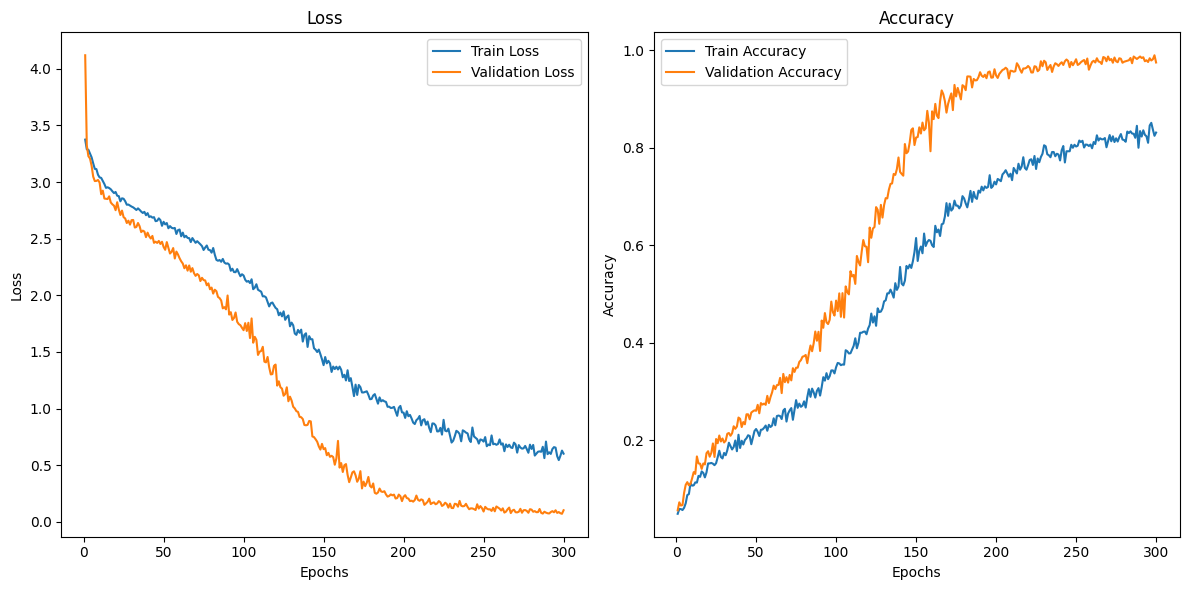

In [18]:
import matplotlib.pyplot as plt

# 성능 기록을 위한 리스트 초기화
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train_model(model, criterion, optimizer, num_epochs=300):
    start_time = time.time()
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # tqdm 적용 (train)
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_dataset)
        epoch_accuracy = correct / total

        # 손실과 정확도 기록
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(test_dataset)
        val_accuracy = val_correct / val_total

        # 검증 손실과 정확도 기록
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Best model 저장
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model(EfficientNetV2).pth")

    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time//60:.0f}m {elapsed_time%60:.0f}s")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

    # 학습이 끝난 후 그래프 저장 및 출력
    plot_and_save_performance()

# 성능 그래프 그리기 및 저장
def plot_and_save_performance():
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 그래프 저장
    plt.tight_layout()
    plt.savefig('training_validation_performance.png')
    plt.show()

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# EfficientNetV2 모델 정의
model = EfficientNetV2(num_classes=len(unique_labels)).to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
train_model(model, criterion, optimizer, num_epochs=300)
